#### Transfer Learning for Image Classification using Torchvision

图片分类问题：交通标志图片的分类
进行fine-tune预训练模型对交通标识进行分类

In [34]:
import torch, torchvision

from pathlib import Path
import numpy as np
import cv2
import pandas as pd 
from tqdm import tqdm
import PIL.Image as Image
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from matplotlib.ticker import MaxNLocator
from torch.optim import lr_scheduler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from glob import glob
import shutil 
from collections import defaultdict 

from torch import nn, optim

import torch.nn.functional as F
import torchvision.transforms as T
from torch.utils.data import DataLoader
from torchvision import models
from torchvision.datasets import ImageFolder

In [5]:
%matplotlib inline
%config InlineBackend.figure_format='retina'

sns.set(style='whitegrid', palette='muted', font_scale=1.2)

HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]

sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))

rcParams['figure.figsize']=12, 8

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [9]:
!unzip -qq GTSRB_Final_Training_Images.zip

In [10]:
train_folders = sorted(glob('GTSRB/Final_Training/Images/*'))

In [101]:
train_folders

['GTSRB/Final_Training/Images\\00000',
 'GTSRB/Final_Training/Images\\00001',
 'GTSRB/Final_Training/Images\\00002',
 'GTSRB/Final_Training/Images\\00003',
 'GTSRB/Final_Training/Images\\00004',
 'GTSRB/Final_Training/Images\\00005',
 'GTSRB/Final_Training/Images\\00006',
 'GTSRB/Final_Training/Images\\00007',
 'GTSRB/Final_Training/Images\\00008',
 'GTSRB/Final_Training/Images\\00009',
 'GTSRB/Final_Training/Images\\00010',
 'GTSRB/Final_Training/Images\\00011',
 'GTSRB/Final_Training/Images\\00012',
 'GTSRB/Final_Training/Images\\00013',
 'GTSRB/Final_Training/Images\\00014',
 'GTSRB/Final_Training/Images\\00015',
 'GTSRB/Final_Training/Images\\00016',
 'GTSRB/Final_Training/Images\\00017',
 'GTSRB/Final_Training/Images\\00018',
 'GTSRB/Final_Training/Images\\00019',
 'GTSRB/Final_Training/Images\\00020',
 'GTSRB/Final_Training/Images\\00021',
 'GTSRB/Final_Training/Images\\00022',
 'GTSRB/Final_Training/Images\\00023',
 'GTSRB/Final_Training/Images\\00024',
 'GTSRB/Final_Training/Im

In [11]:
len(train_folders)

43

使用OpenCV和Torchvision加载和展示图片

In [12]:
'''
加载图片 
'''
def load_image(img_path, resize = True):
    #图像颜色空间转换
    img = cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2RGB)
    
    if resize:
        #src，dsize，interpolation表示插值方式
        img = cv2.resize(img, (64,64), interpolation=cv2.INTER_AREA)
    
    return img 

def show_image(img_path):
    img = load_image(img_path)
    plt.imshow(img)
    plt.axis('off')

def show_sign_grid(image_paths):
    #将img_paths下的所有img都load进来并且以列表形式存储在images
    images = [load_image(img) for img in image_paths]
    images = torch.as_tensor(images)
    #permute()函数进行维度置换
    images = images.permute(0,3,1,2)
    #make_grid()作用是将若干幅图像拼接为一幅图像
    grid_img = torchvision.utils.make_grid(images, nrow=11)
    plt.figure(figsize=(24,12))
    plt.imshow(grid_img.permute(1,2,0))
    plt.axis('off');

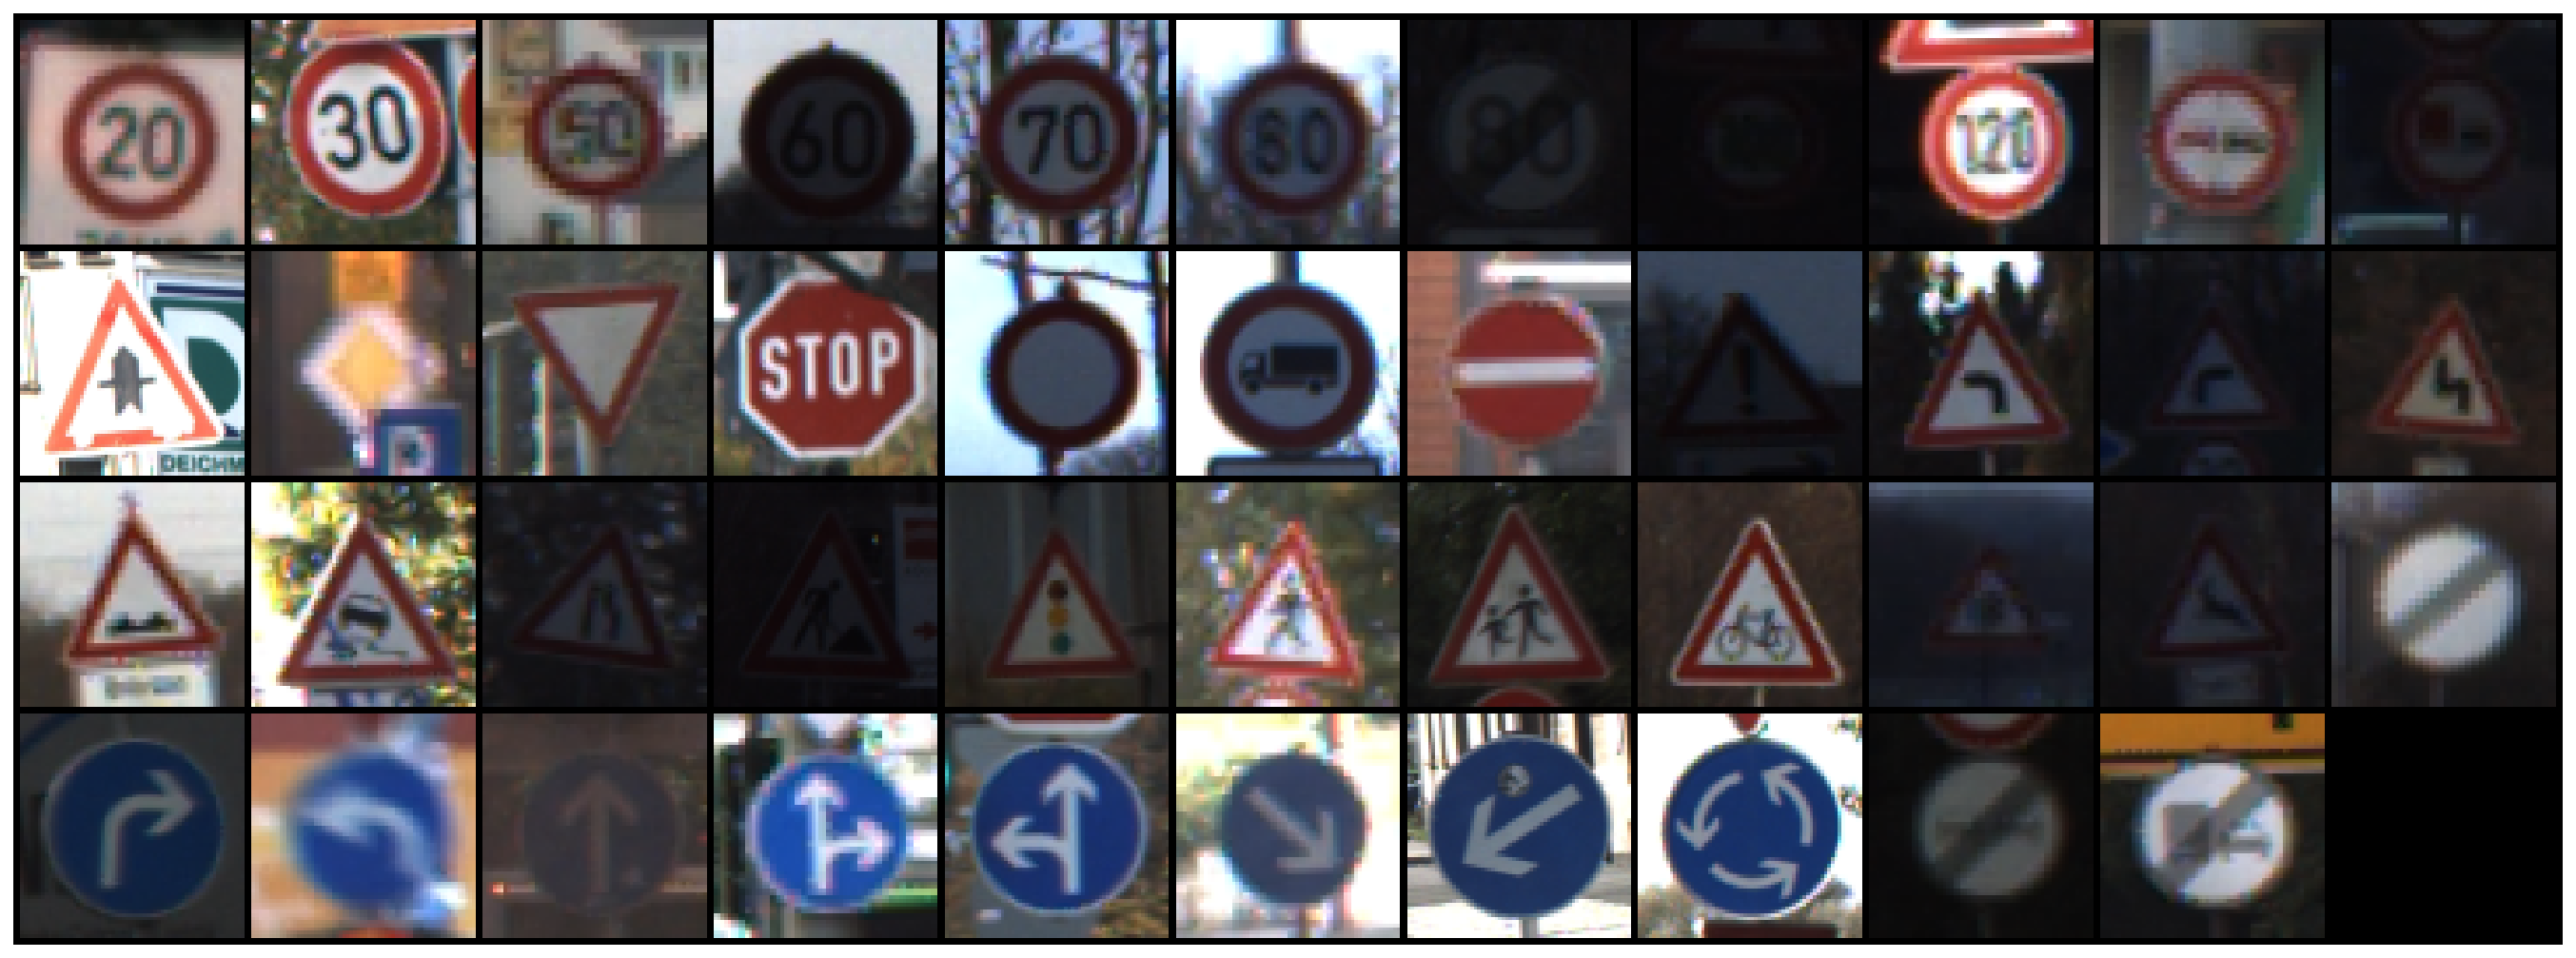

In [13]:
'''
查看部分的交通标志的图案
'''
sample_images = [np.random.choice(glob(f'{tf}/*ppm')) for tf in train_folders]
show_sign_grid(sample_images)

In [102]:
sample_images

['GTSRB/Final_Training/Images\\00000\\00003_00012.ppm',
 'GTSRB/Final_Training/Images\\00001\\00028_00020.ppm',
 'GTSRB/Final_Training/Images\\00002\\00043_00004.ppm',
 'GTSRB/Final_Training/Images\\00003\\00037_00020.ppm',
 'GTSRB/Final_Training/Images\\00004\\00036_00015.ppm',
 'GTSRB/Final_Training/Images\\00005\\00057_00014.ppm',
 'GTSRB/Final_Training/Images\\00006\\00000_00020.ppm',
 'GTSRB/Final_Training/Images\\00007\\00004_00001.ppm',
 'GTSRB/Final_Training/Images\\00008\\00015_00016.ppm',
 'GTSRB/Final_Training/Images\\00009\\00041_00008.ppm',
 'GTSRB/Final_Training/Images\\00010\\00011_00000.ppm',
 'GTSRB/Final_Training/Images\\00011\\00002_00027.ppm',
 'GTSRB/Final_Training/Images\\00012\\00004_00010.ppm',
 'GTSRB/Final_Training/Images\\00013\\00056_00005.ppm',
 'GTSRB/Final_Training/Images\\00014\\00010_00008.ppm',
 'GTSRB/Final_Training/Images\\00015\\00011_00013.ppm',
 'GTSRB/Final_Training/Images\\00016\\00013_00023.ppm',
 'GTSRB/Final_Training/Images\\00017\\00026_0002

In [18]:
img_path = glob(f'{train_folders[16]}/*ppm')[1]

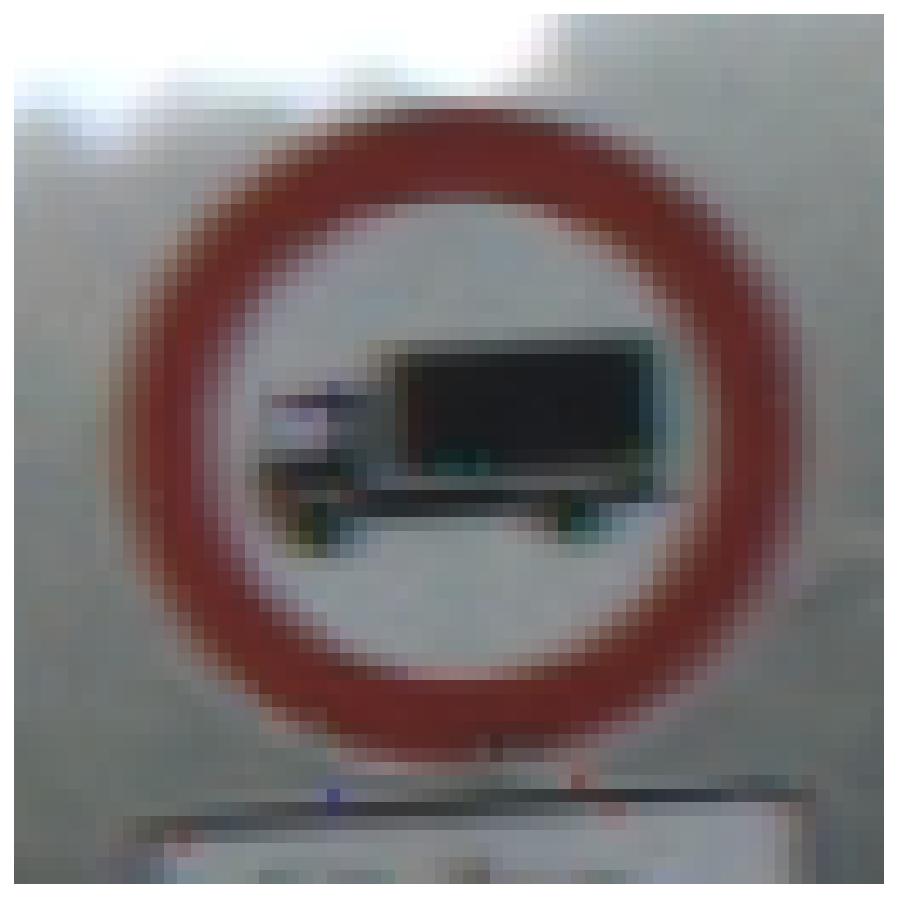

In [19]:
show_image(img_path)

还是简单化处理，这里我们只挑选其中的几个标志来进行分类问题的练习

这里挑选出部分图片构建一个新的数据集

In [20]:
class_names = ['priority_road', 'give_way', 'stop','no_entry']

class_indices = [12,13,14,17]

In [23]:
'''
使用Torchvision dataset helpers将图片文件复制到一个新的路径下
'''
DATA_DIR = Path('data')

In [24]:
DATASETS = ['train', 'val', 'test']

In [25]:
'''
创建数据集
分为train，validation，test三个大类 
每一个大类中按照图片的标签分为4类标签 
'''
for ds in DATASETS:
    for cls in class_names:
        (DATA_DIR/ds/cls).mkdir(parents=True,exist_ok=True)

In [105]:
train_folders[17]

'GTSRB/Final_Training/Images\\00017'

In [106]:
'''
对于每一个类别的推图片保留80%的数据用于训练，10%用于验证，10%用于测试
将图片数据存放到对应的文件夹下
'''
for i, cls_index in enumerate(class_indices):
    #找到需要的类别的数据的路径
    image_paths = np.array(glob(f'{train_folders[cls_index]}/*ppm'))
    class_name = class_names[i]
    print(f'{class_name}: {len(image_paths)}')
    np.random.shuffle(image_paths)
    #数据集的划分
    #使用np.split函数将单类别的数据分为train，test，validation
    ds_split = np.split(
        image_paths,
        indices_or_sections=[int(.8*len(image_paths)),int(.9*len(image_paths))]
    )
    print(ds_split)
    dataset_data = zip(DATASETS,ds_split)
    
    for ds, images in dataset_data:
        for img_path in images:
            '''
            shutil用于处理文件操作的模块
            '''
            shutil.copy(img_path, f'{DATA_DIR}/{ds}/{class_name}/')

give_way: 2100
[array(['GTSRB/Final_Training/Images\\00012\\00003_00028.ppm',
       'GTSRB/Final_Training/Images\\00012\\00056_00019.ppm',
       'GTSRB/Final_Training/Images\\00012\\00003_00003.ppm', ...,
       'GTSRB/Final_Training/Images\\00012\\00002_00001.ppm',
       'GTSRB/Final_Training/Images\\00012\\00057_00029.ppm',
       'GTSRB/Final_Training/Images\\00012\\00001_00022.ppm'],
      dtype='<U49'), array(['GTSRB/Final_Training/Images\\00012\\00028_00005.ppm',
       'GTSRB/Final_Training/Images\\00012\\00038_00016.ppm',
       'GTSRB/Final_Training/Images\\00012\\00016_00021.ppm',
       'GTSRB/Final_Training/Images\\00012\\00041_00014.ppm',
       'GTSRB/Final_Training/Images\\00012\\00021_00015.ppm',
       'GTSRB/Final_Training/Images\\00012\\00018_00009.ppm',
       'GTSRB/Final_Training/Images\\00012\\00020_00018.ppm',
       'GTSRB/Final_Training/Images\\00012\\00056_00002.ppm',
       'GTSRB/Final_Training/Images\\00012\\00059_00025.ppm',
       'GTSRB/Final_Trainin

no_entry: 2160
[array(['GTSRB/Final_Training/Images\\00013\\00005_00008.ppm',
       'GTSRB/Final_Training/Images\\00013\\00044_00014.ppm',
       'GTSRB/Final_Training/Images\\00013\\00033_00026.ppm', ...,
       'GTSRB/Final_Training/Images\\00013\\00011_00005.ppm',
       'GTSRB/Final_Training/Images\\00013\\00007_00027.ppm',
       'GTSRB/Final_Training/Images\\00013\\00000_00027.ppm'],
      dtype='<U49'), array(['GTSRB/Final_Training/Images\\00013\\00067_00023.ppm',
       'GTSRB/Final_Training/Images\\00013\\00071_00018.ppm',
       'GTSRB/Final_Training/Images\\00013\\00006_00029.ppm',
       'GTSRB/Final_Training/Images\\00013\\00056_00026.ppm',
       'GTSRB/Final_Training/Images\\00013\\00050_00024.ppm',
       'GTSRB/Final_Training/Images\\00013\\00045_00004.ppm',
       'GTSRB/Final_Training/Images\\00013\\00021_00003.ppm',
       'GTSRB/Final_Training/Images\\00013\\00064_00017.ppm',
       'GTSRB/Final_Training/Images\\00013\\00055_00019.ppm',
       'GTSRB/Final_Trainin

priority_road: 780
[array(['GTSRB/Final_Training/Images\\00014\\00006_00019.ppm',
       'GTSRB/Final_Training/Images\\00014\\00014_00015.ppm',
       'GTSRB/Final_Training/Images\\00014\\00002_00013.ppm',
       'GTSRB/Final_Training/Images\\00014\\00010_00027.ppm',
       'GTSRB/Final_Training/Images\\00014\\00002_00014.ppm',
       'GTSRB/Final_Training/Images\\00014\\00022_00012.ppm',
       'GTSRB/Final_Training/Images\\00014\\00002_00029.ppm',
       'GTSRB/Final_Training/Images\\00014\\00015_00027.ppm',
       'GTSRB/Final_Training/Images\\00014\\00017_00019.ppm',
       'GTSRB/Final_Training/Images\\00014\\00014_00006.ppm',
       'GTSRB/Final_Training/Images\\00014\\00023_00006.ppm',
       'GTSRB/Final_Training/Images\\00014\\00016_00009.ppm',
       'GTSRB/Final_Training/Images\\00014\\00020_00024.ppm',
       'GTSRB/Final_Training/Images\\00014\\00009_00001.ppm',
       'GTSRB/Final_Training/Images\\00014\\00005_00004.ppm',
       'GTSRB/Final_Training/Images\\00014\\00015_

stop: 1110
[array(['GTSRB/Final_Training/Images\\00017\\00001_00006.ppm',
       'GTSRB/Final_Training/Images\\00017\\00024_00020.ppm',
       'GTSRB/Final_Training/Images\\00017\\00005_00017.ppm',
       'GTSRB/Final_Training/Images\\00017\\00002_00012.ppm',
       'GTSRB/Final_Training/Images\\00017\\00030_00010.ppm',
       'GTSRB/Final_Training/Images\\00017\\00031_00007.ppm',
       'GTSRB/Final_Training/Images\\00017\\00006_00014.ppm',
       'GTSRB/Final_Training/Images\\00017\\00029_00003.ppm',
       'GTSRB/Final_Training/Images\\00017\\00018_00016.ppm',
       'GTSRB/Final_Training/Images\\00017\\00009_00020.ppm',
       'GTSRB/Final_Training/Images\\00017\\00006_00027.ppm',
       'GTSRB/Final_Training/Images\\00017\\00009_00011.ppm',
       'GTSRB/Final_Training/Images\\00017\\00033_00026.ppm',
       'GTSRB/Final_Training/Images\\00017\\00020_00019.ppm',
       'GTSRB/Final_Training/Images\\00017\\00015_00002.ppm',
       'GTSRB/Final_Training/Images\\00017\\00015_00026.pp

进行一下数据增强

In [29]:
mean_nums = [0.485,0.456,0.406]
std_nums = [0.229,0.224,0.225]

transforms = {'train': T.Compose([
    T.RandomResizedCrop(size=256),
    T.RandomRotation(degrees=15),
    T.RandomHorizontalFlip(),
    T.ToTensor(),
    T.Normalize(mean_nums, std_nums)]), 
    'val': T.Compose([
    T.Resize(size=256),
    T.CenterCrop(size=224),
    T.ToTensor(),
    T.Normalize(mean_nums, std_nums)]), 
    'test': T.Compose([
    T.Resize(size=256),
    T.CenterCrop(size=224),
    T.ToTensor(),
    T.Normalize(mean_nums, std_nums)]),
}

In [36]:
'''
创建dataset folder和data loader
'''
image_datasets = {
    d:ImageFolder(f'{DATA_DIR}/{d}',transforms[d]) for d in DATASETS
}

data_loaders = {
    d:DataLoader(image_datasets[d],batch_size=4,shuffle=True,num_workers=4)
    for d in DATASETS
}

In [107]:
image_datasets

{'train': Dataset ImageFolder
     Number of datapoints: 5741
     Root location: data/train
     StandardTransform
 Transform: Compose(
                RandomResizedCrop(size=(256, 256), scale=(0.08, 1.0), ratio=(0.75, 1.3333), interpolation=PIL.Image.BILINEAR)
                RandomRotation(degrees=(-15, 15), resample=False, expand=False)
                RandomHorizontalFlip(p=0.5)
                ToTensor()
                Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
            ),
 'val': Dataset ImageFolder
     Number of datapoints: 886
     Root location: data/val
     StandardTransform
 Transform: Compose(
                Resize(size=256, interpolation=PIL.Image.BILINEAR)
                CenterCrop(size=(224, 224))
                ToTensor()
                Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
            ),
 'test': Dataset ImageFolder
     Number of datapoints: 884
     Root location: data/test
     StandardTransform
 Transform:

In [110]:
data_loaders['train']

In [37]:
dataset_sizes = {d: len(image_datasets[d]) for d in DATASETS}
class_names = image_datasets['train'].classes

dataset_sizes

{'train': 4920, 'val': 615, 'test': 615}

In [111]:
class_names

['give_way', 'no_entry', 'priority_road', 'stop', 'unknown']

In [38]:
'''
展示一部分数据增强后的图片
'''
def imshow1(inp, title=None):
    inp = inp.numpy().transpose((1,2,0))
    mean = np.array([mean_nums])
    std = np.array([std_nums])
    inp = std*inp + mean 
    inp = np.clip(inp,0,1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.axis('off')

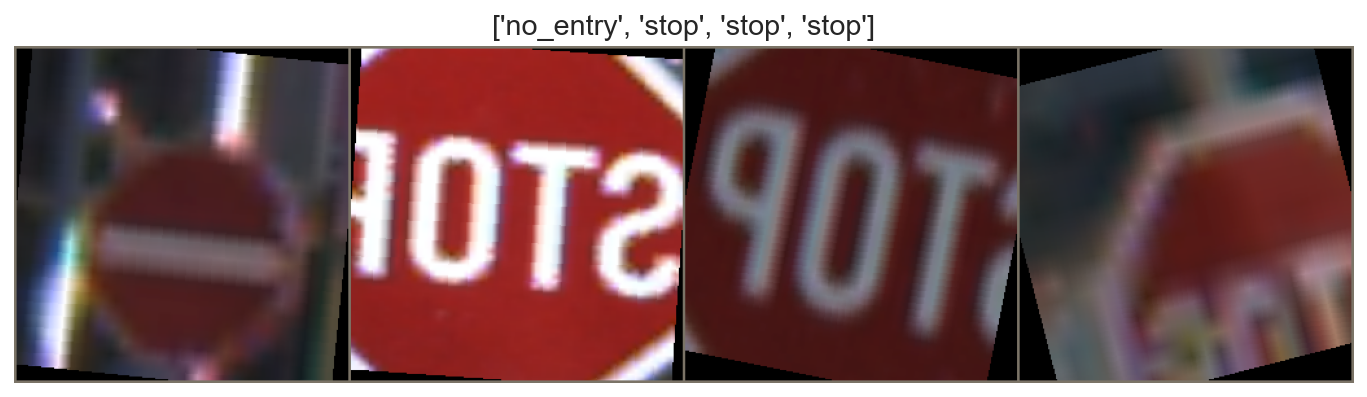

In [39]:
inputs,classes = next(iter(data_loaders['train']))
out = torchvision.utils.make_grid(inputs)

imshow1(out, title=[class_names[x] for x in classes])

In [112]:
inputs

tensor([[[[-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
          [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
          [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
          ...,
          [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
          [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
          [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179]],

         [[-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
          [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
          [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
          ...,
          [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
          [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
          [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357]],

         [[-1.8044, -1.8044, -1.8044,  ..., -1.8044, -1.8044, -1.8044],
          [-1.8044, -1.8044, -

###### Using a pre-trained model

使用迁移学习的知识，借用ResNet的模型，我们使用到的权重是训练ImageNet数据集得到的权重

In [113]:
classes

tensor([1, 3, 3, 3])

In [40]:
def create_model(n_classes):
    model = models.resnet34(pretrained=True)
    
    n_features = model.fc.in_features
    model.fc = nn.Linear(n_features, n_classes)
    
    return model.to(device)

In [41]:
'''
%xdel要对输出层的神经元数量进行调整
因为简化后的分类问题类别远远少于ImageNet数据集的类别数量 
'''
base_model = create_model(len(class_names))

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to C:\Users\guoyu/.cache\torch\checkpoints\resnet34-333f7ec4.pth


In [42]:
def train_epoch(
    model,
    data_loader,
    loss_fn,
    optimizer,
    device,
    scheduler,
    n_examples
):
    model = model.train()
    
    losses = []
    correct_predictions = 0
    
    for inputs, labels in data_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        
        outputs = model(inputs)
        
        _, preds = torch.max(outputs, dim=1)
        loss = loss_fn(outputs, labels)
        
        correct_predictions += torch.sum(preds == labels)
        losses.append(loss.item())
        
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
    
    scheduler.step()
    
    return correct_predictions.double() / n_examples, np.mean(losses)      

In [43]:
def eval_model(model, data_loader, loss_fn, device, n_examples):
    model = model.eval()
    
    losses = []
    correct_predictions = 0
    
    with torch.no_grad():
        for inputs, labels in data_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            outputs = model(inputs)
            
            _, preds = torch.max(outputs,dim=1)
            
            loss = loss_fn(outputs, labels)
            
            correct_predictions += torch.sum(preds == labels)
            losses.append(loss.item())
    return correct_predictions.double() / n_examples, np.mean(losses)

In [44]:
def train_model(model,data_loaders,dataset_sizes,device,n_epochs=3):
    optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
    scheduler = lr_scheduler.StepLR(optimizer,step_size=7,gamma=0.1)
    loss_fn = nn.CrossEntropyLoss().to(device)
    
    history = defaultdict(list)
    best_accuracy = 0
    
    for epoch in range(n_epochs):
        print(f'Epoch {epoch+1}/{n_epochs}')
        print('-' * 10)
        
        train_acc, train_loss = train_epoch(
            model,
            data_loaders['train'],
            loss_fn,
            optimizer,
            device,
            scheduler,
            dataset_sizes['train']
        )
        
        print(f'Train Loss {train_loss} accuracy {train_acc}')
        
        val_acc, val_loss = eval_model(
            model,
            data_loaders['val'],
            loss_fn,
            device,
            dataset_sizes['val']
        )
        
        print(f'Val  loss {val_loss} accuracy {val_acc}')
        print()
        
        history['train_acc'].append(train_acc)
        history['train_loss'].append(train_loss)
        history['val_acc'].append(val_acc)
        history['val_loss'].append(val_loss)
        
        if val_acc > best_accuracy:
            torch.save(model.state_dict(), 'best_model_state.bin')
            best_accuracy = val_acc
    
    print(f'Best val accuracy: {best_accuracy}')
    
    model.load_state_dict(torch.load('best_model_state.bin'))
    
    return model, history

In [46]:
%%time

base_model, history = train_model(base_model, data_loaders,dataset_sizes,device)

Epoch 1/3
----------
Train Loss 0.21354113768003463 accuracy 0.9345528455284553
Val  loss 0.0015147303451890544 accuracy 1.0

Epoch 2/3
----------
Train Loss 0.12650512127243943 accuracy 0.958130081300813
Val  loss 0.0005959288599738161 accuracy 1.0

Epoch 3/3
----------
Train Loss 0.07359448281334234 accuracy 0.9768292682926829
Val  loss 0.0012270082788597995 accuracy 1.0

Best val accuracy: 1.0
Wall time: 1h 30min 36s


In [49]:
def plot_training_history(history):
    fig, (ax1, ax2) = plt.subplots(1,2,figsize=(18,6))
    ax1.plot(history['train_loss'],label='train loss')
    ax1.plot(history['val_loss'],label='validation loss')
    
    ax1.xaxis.set_major_locator(MaxNLocator(integer=True))
    ax1.set_ylim([-0.05,1.05])
    ax1.legend()
    ax1.set_ylabel('Loss')
    ax1.set_xlabel('Epoch')
    
    ax2.plot(history['train_acc'],label='train accuracy')
    ax2.plot(history['val_acc'],label='validation accuracy')
    
    ax2.xaxis.set_major_locator(MaxNLocator(integer=True))
    ax2.set_ylim([-0.05,1.05])
    ax2.legend()
    ax2.set_ylabel('Accuracy')
    ax2.set_xlabel('Epoch')
    
    fig.suptitle('Training History')

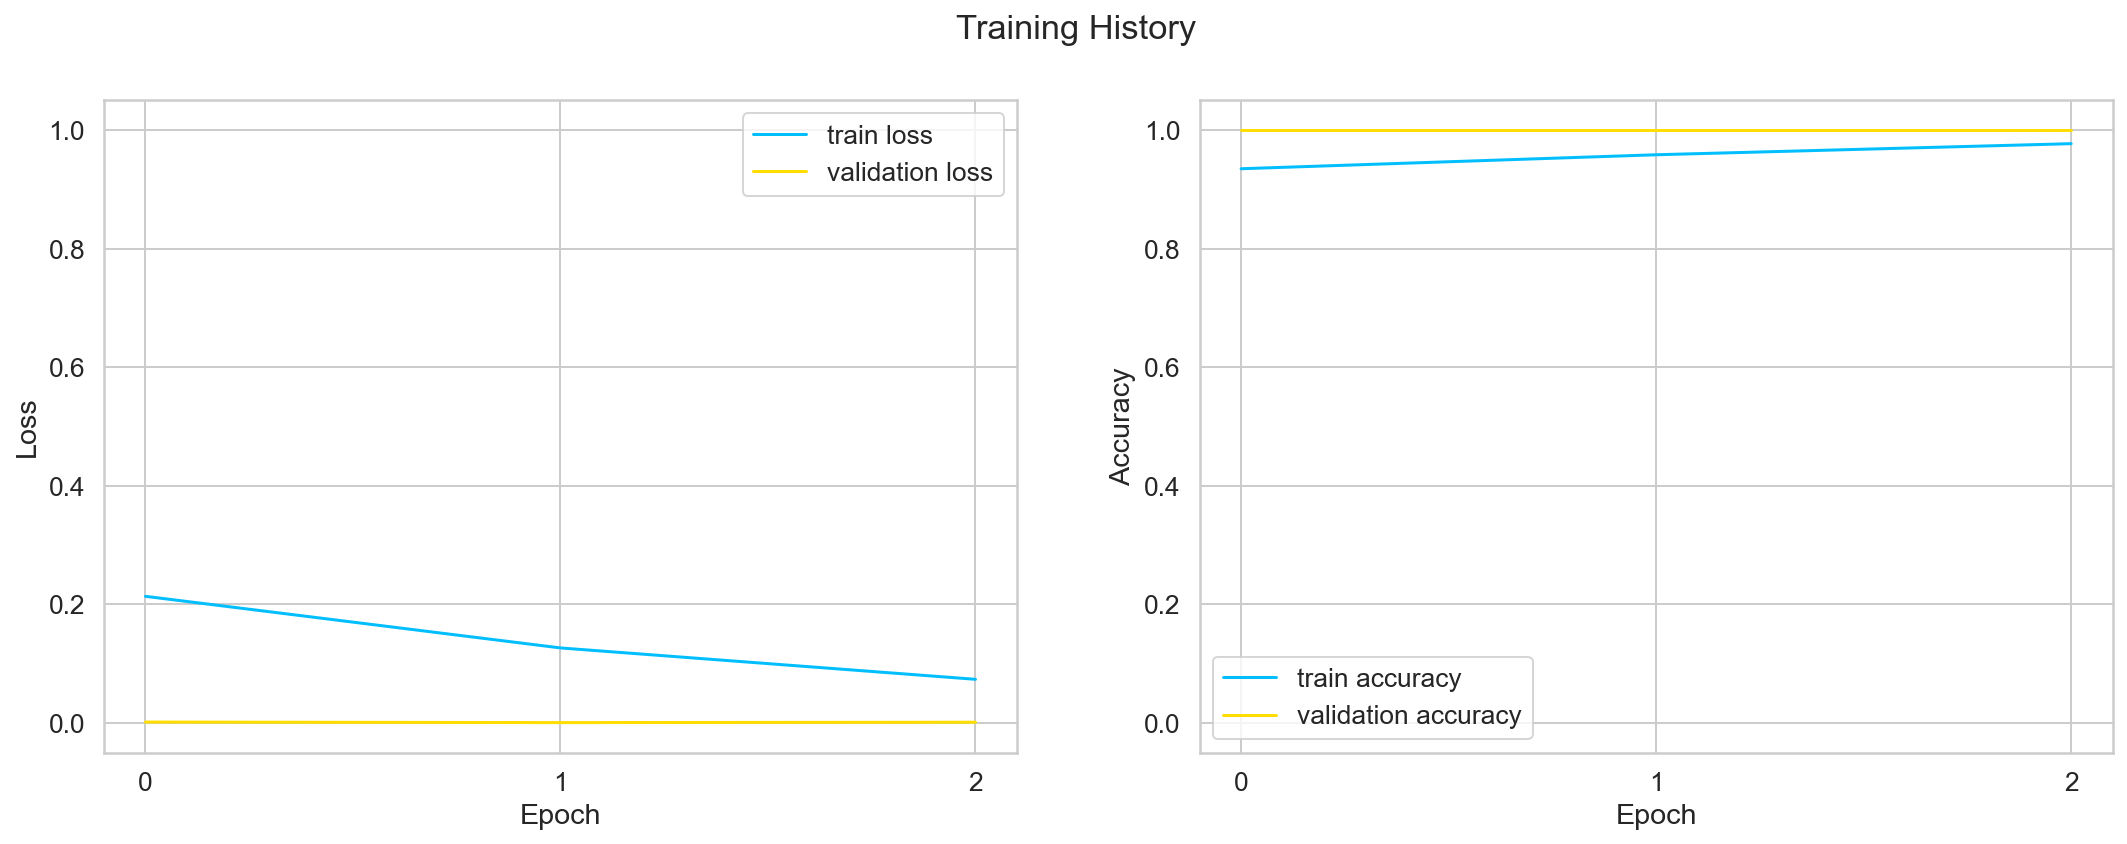

In [50]:
plot_training_history(history)

###### Evaluation
利用训练好的模型展示一下其识别的结果

In [51]:
def show_prediction(model,class_names, n_images=6):
    model = model.eval()
    images_handled = 0
    plt.figure()
    
    with torch.no_grad():
        for i, (inputs, labels) in enumerate(data_loaders['test']):
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            outputs = model(inputs)
            _, preds = torch.max(outputs,1)
            
            for j in range(inputs.shape[0]):
                images_handled += 1
                ax = plt.subplot(2,n_images//2, images_handled)
                ax.set_title(f'predicted:{class_names[preds[j]]}')
                imshow1(inputs.cpu().data[j])
                ax.axis('off')
                
                if images_handled == n_images:
                    return 

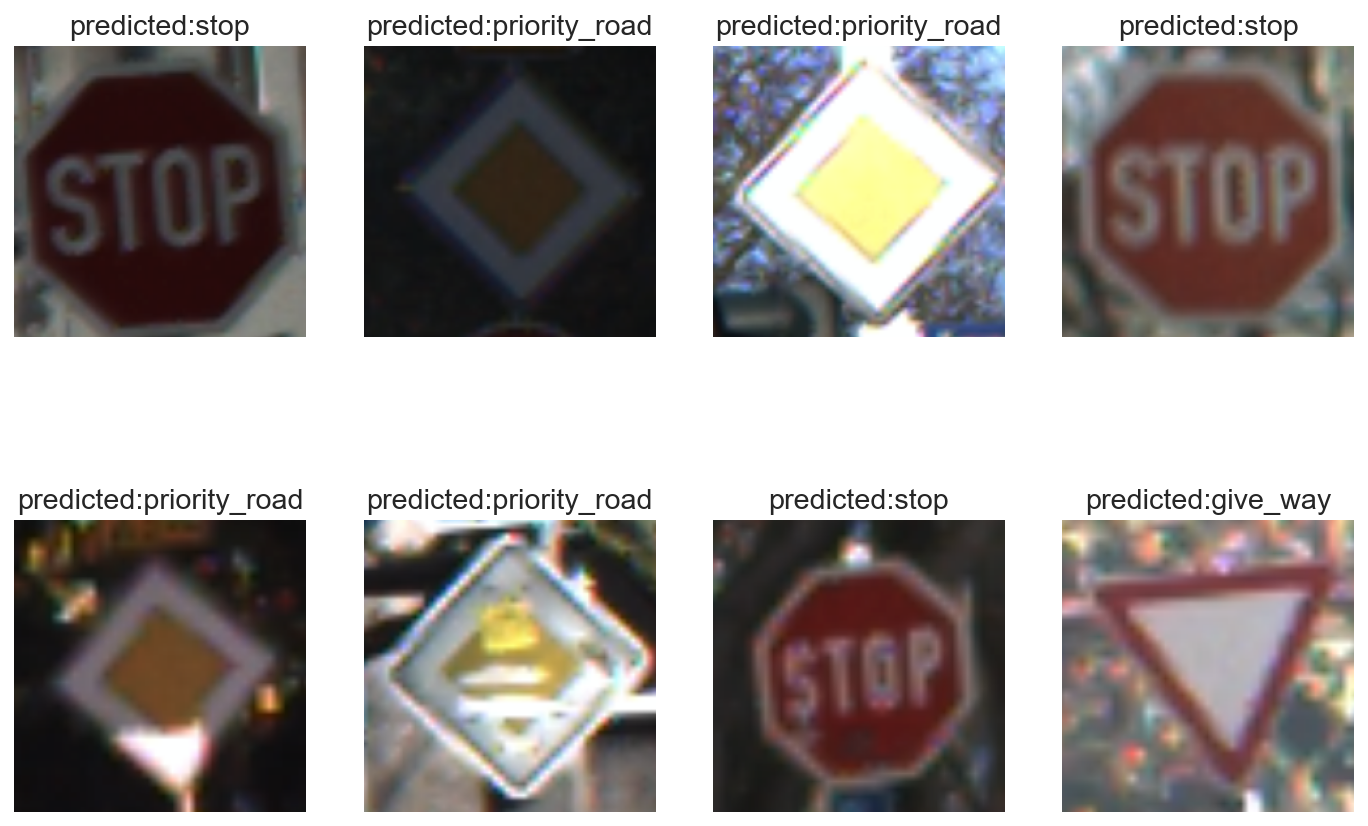

In [52]:
show_prediction(base_model,class_names,n_images=8)

In [53]:
def get_predictions(model, data_loader):
    model = model.eval()
    predictions = []
    real_values = []
    with torch.no_grad():
        for inputs, labels in data_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            outputs = model(inputs)
            _,preds = torch.max(outputs,1)
            predictions.extend(preds)
            real_values.extend(labels)
    predictions = torch.as_tensor(predictions).cpu()
    real_values = torch.as_tensor(real_values).cpu()
    return predictions,real_values

In [54]:
y_pred,y_test = get_predictions(base_model,data_loaders['test'])

In [55]:
print(classification_report(y_test,y_pred,target_names=class_names))

               precision    recall  f1-score   support

     give_way       1.00      1.00      1.00       216
     no_entry       1.00      1.00      1.00       111
priority_road       1.00      1.00      1.00       210
         stop       1.00      1.00      1.00        78

     accuracy                           1.00       615
    macro avg       1.00      1.00      1.00       615
 weighted avg       1.00      1.00      1.00       615



##### Incredible!

In [60]:
'''
绘制热力图
'''
def show_confusion_matrix(confusion_matrix,class_names):
    cm = confusion_matrix.copy()
    
    cell_counts = cm.flatten()
    
    cm_row_norm = cm / cm.sum(axis=1)[:,np.newaxis]
    
    row_percentages = ["{0:.2f}".format(value) for value in cm_row_norm.flatten()]
    cell_labels = [f"{cnt}\n{per}" for cnt,per in zip(cell_counts,row_percentages)]
    cell_labels = np.asarray(cell_labels).reshape(cm.shape[0],cm.shape[1])
    
    df_cm = pd.DataFrame(cm_row_norm, index=class_names, columns=class_names)
    
    hmap = sns.heatmap(df_cm,annot=cell_labels, fmt='',cmap='Blues')
    hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(),rotation=0,ha='right')
    hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(),rotation=30,ha='right')
    plt.ylabel('True Sign')
    plt.xlabel('Prediction Sign')

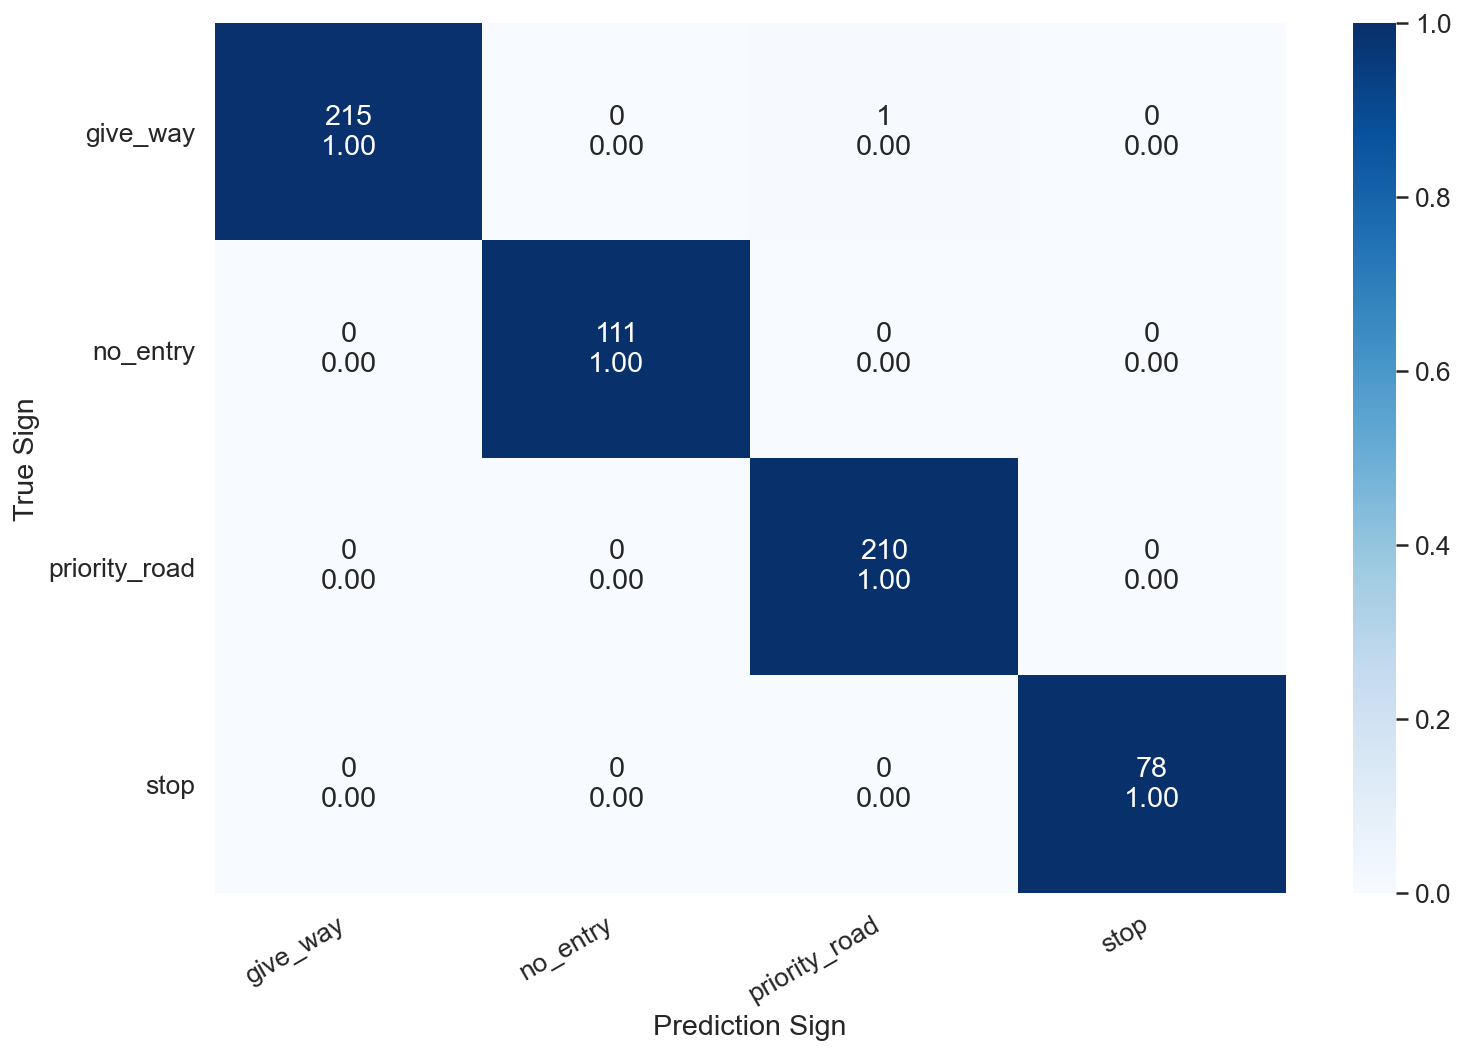

In [61]:
cm = confusion_matrix(y_test,y_pred)
show_confusion_matrix(cm,class_names)

##### 对没有见过的signs进行分类

In [63]:
!gdown --id 19Qz3a61Ou_QSHsLeTznx8LtDBu4tbqHr

Downloading...
From: https://drive.google.com/uc?id=19Qz3a61Ou_QSHsLeTznx8LtDBu4tbqHr
To: E:\Code\Python\Torch_Learning\stop-sign.jpg

  0%|          | 0.00/77.3k [00:00<?, ?B/s]
100%|██████████| 77.3k/77.3k [00:00<00:00, 106kB/s]
100%|██████████| 77.3k/77.3k [00:00<00:00, 104kB/s]


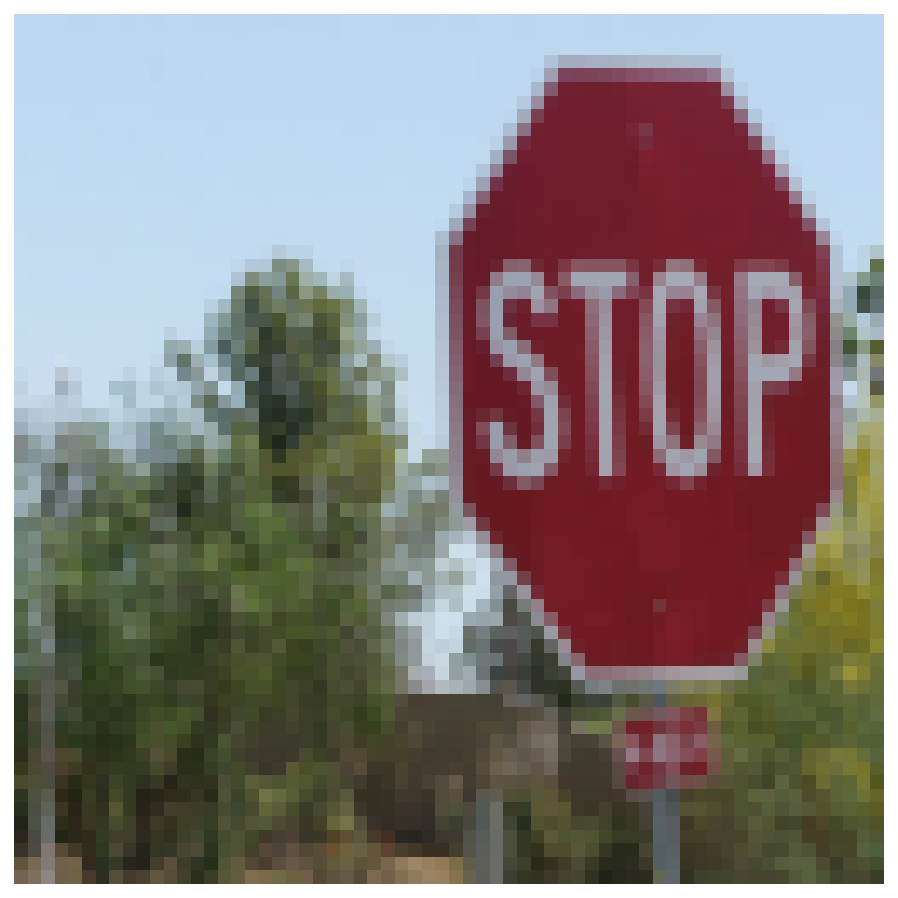

In [64]:
show_image('stop-sign.jpg')

In [66]:
def predict_proba(model,image_path):
    img = Image.open(image_path)
    img = img.convert('RGB')
    img = transforms['test'](img).unsqueeze(0)
    
    pred = model(img.to(device))
    pred = F.softmax(pred,dim=1)
    return pred.detach().cpu().numpy().flatten()

In [67]:
pred = predict_proba(base_model, 'stop-sign.jpg')

In [68]:
pred

array([0.03230797, 0.14153342, 0.02363726, 0.80252135], dtype=float32)

In [69]:
def show_prediction_confidence(prediction, class_names):
    pred_df = pd.DataFrame({
    'class_names': class_names,
    'values': prediction
    })
    sns.barplot(x='values', y='class_names', data=pred_df, orient='h')
    plt.xlim([0, 1]);

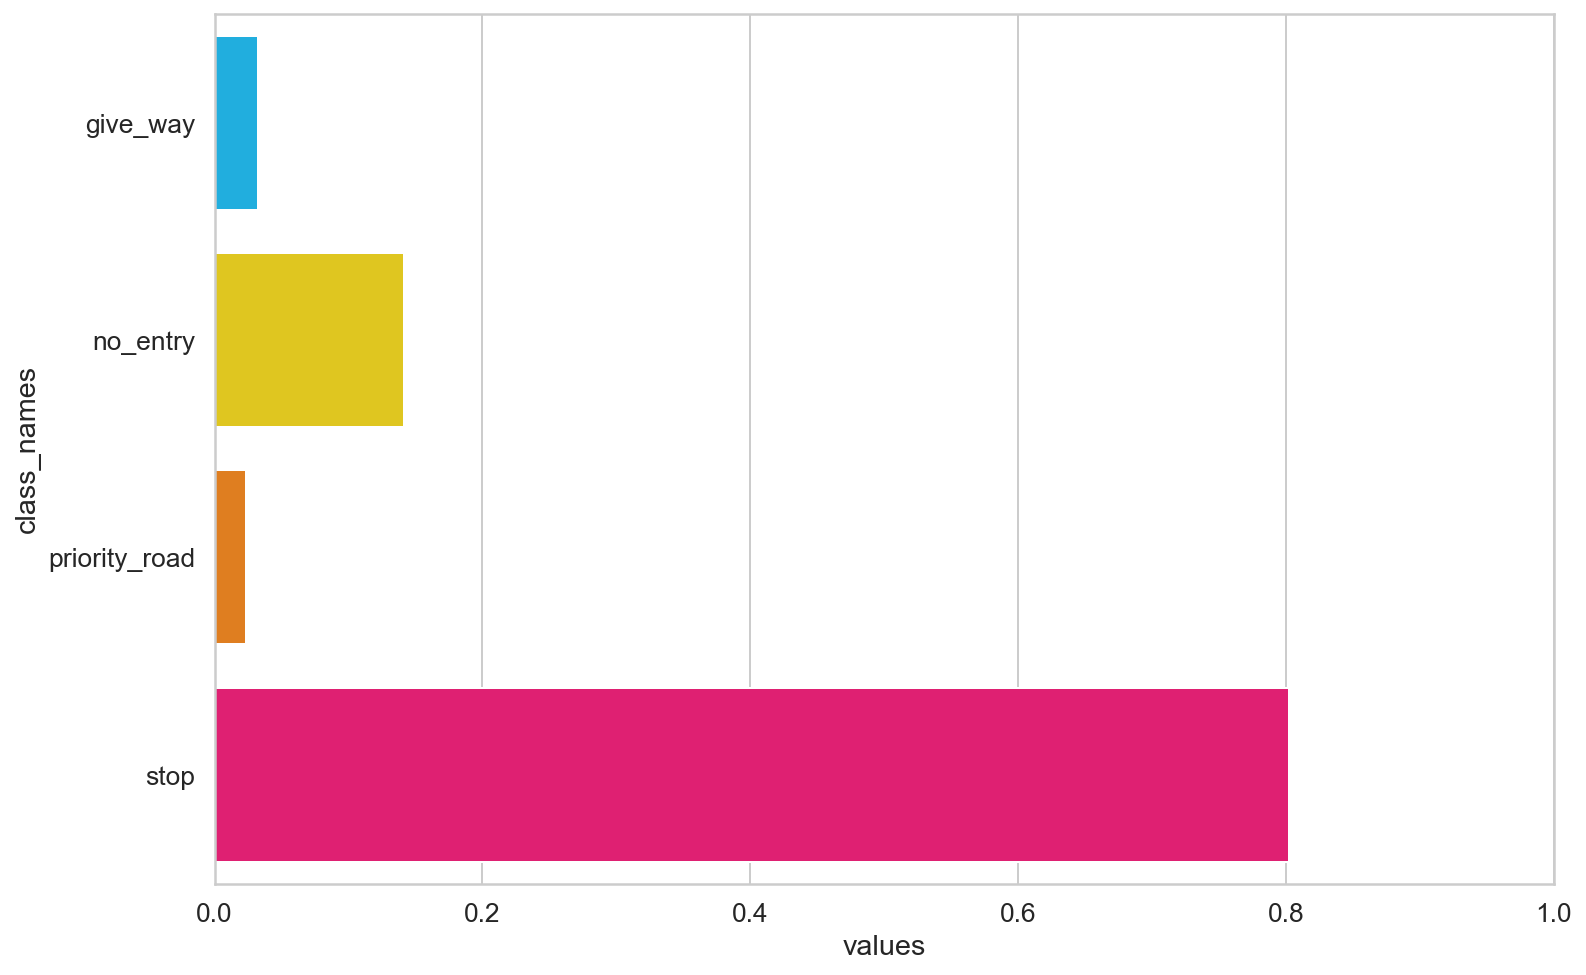

In [70]:
show_prediction_confidence(pred,class_names)

In [71]:
!gdown --id 1F61-iNhlJk-yKZRGcu6S9P29HxDFxF0u

Downloading...
From: https://drive.google.com/uc?id=1F61-iNhlJk-yKZRGcu6S9P29HxDFxF0u
To: E:\Code\Python\Torch_Learning\unknown-sign.jpg

  0%|          | 0.00/41.4k [00:00<?, ?B/s]
100%|██████████| 41.4k/41.4k [00:00<00:00, 648kB/s]


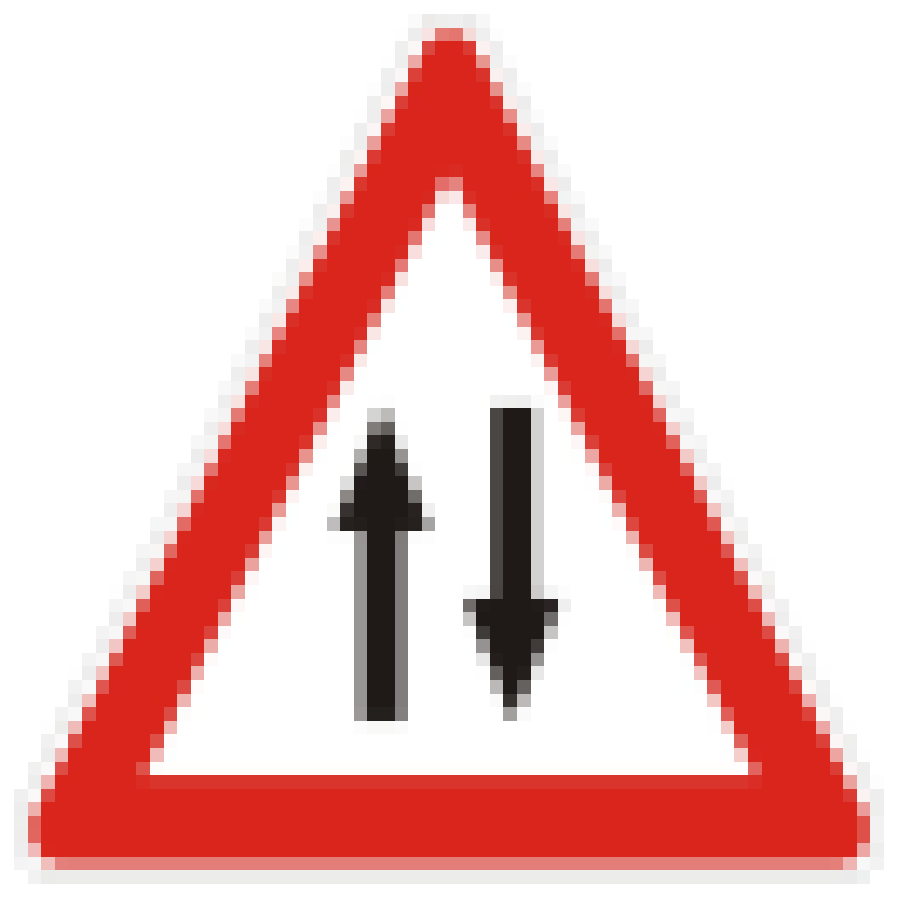

In [75]:
show_image('unknown-sign.jpg')

In [72]:
pred = predict_proba(base_model,'unknown-sign.jpg')

In [73]:
pred

array([0.95597774, 0.00121344, 0.03910958, 0.00369918], dtype=float32)

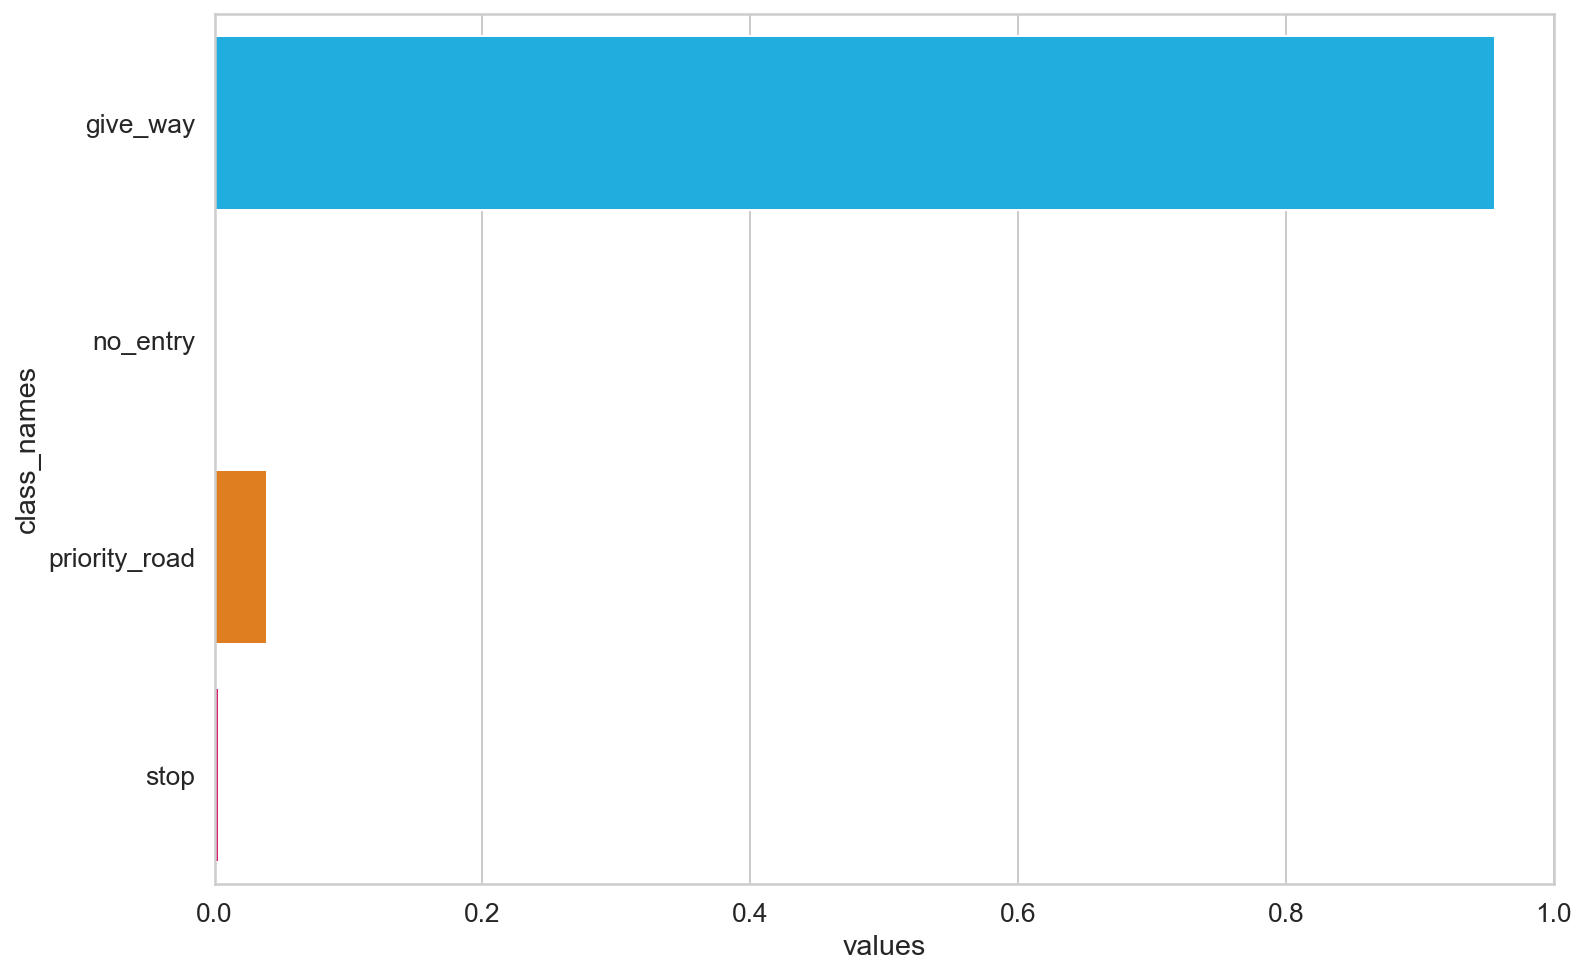

In [74]:
show_prediction_confidence(pred,class_names)

##### Add class “unknown”

In [76]:
unknown_indices = [
    i for i,f in enumerate(train_folders) if i not in class_indices
]

len(unknown_indices)

39

In [89]:
for ds in DATASETS:
    (DATA_DIR/ds/'unknown').mkdir(parents=True,exist_ok=True)

for ui in unknown_indices:
    image_paths = np.array(glob(f'{train_folders[ui]}/*.ppm'))
    image_paths = np.random.choice(image_paths,50)
    
    ds_split = np.split(
        image_paths,
        indices_or_sections = [int(.8*len(image_paths)),int(.9*len(image_paths))]
    )
    
    dataset_data = zip(DATASETS,ds_split)
    
    for ds, images in dataset_data:
        for img_path in images:
            shutil.copy(img_path,f'{DATA_DIR}/{ds}/unknown')

In [91]:
image_datasets = {
    d: ImageFolder(f'{DATA_DIR}/{d}', transforms[d]) for d in DATASETS
}

data_loaders = {
    d: DataLoader(image_datasets[d],batch_size=4,shuffle=True,num_workers=4) for d in DATASETS
}

dataset_sizes = {d: len(image_datasets[d]) for d in DATASETS}

class_names = image_datasets['train'].classes

dataset_sizes

{'train': 5741, 'val': 886, 'test': 884}

In [92]:
%%time

enchanced_model = create_model(len(class_names))
enchanced_model,history = train_model(enchanced_model,data_loaders,dataset_sizes,device)

Epoch 1/3
----------
Train Loss 0.4568666215492059 accuracy 0.8515937989897231
Val  loss 0.48546193652875264 accuracy 0.891647855530474

Epoch 2/3
----------
Train Loss 0.22563158046698373 accuracy 0.9336352551820241
Val  loss 0.9624531457019132 accuracy 0.8905191873589164

Epoch 3/3
----------
Train Loss 0.16869333942096626 accuracy 0.955756836788016
Val  loss 1.0409256869130405 accuracy 0.8905191873589164

Best val accuracy: 0.891647855530474
Wall time: 1h 46min 34s


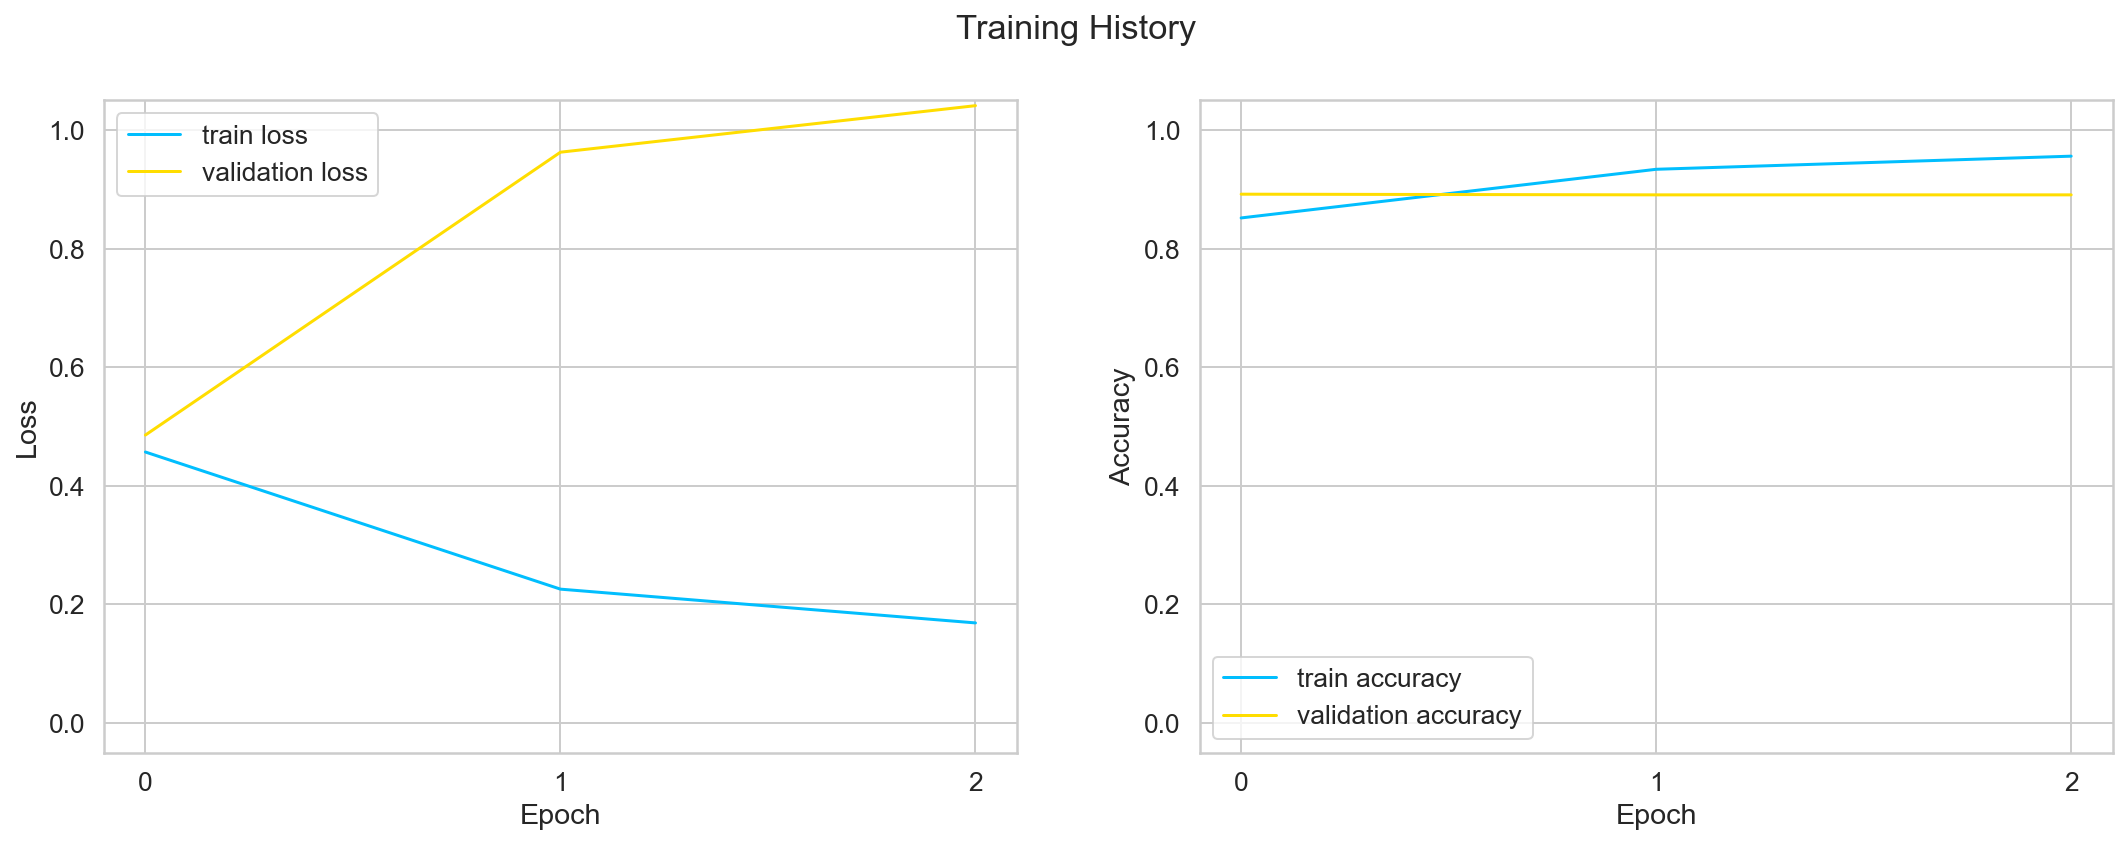

In [93]:
plot_training_history(history)

In [94]:
pred = predict_proba(enchanced_model,'unknown-sign.jpg')

In [95]:
pred

array([4.0488439e-06, 3.9678338e-04, 2.7369566e-07, 3.8594182e-05,
       9.9956030e-01], dtype=float32)

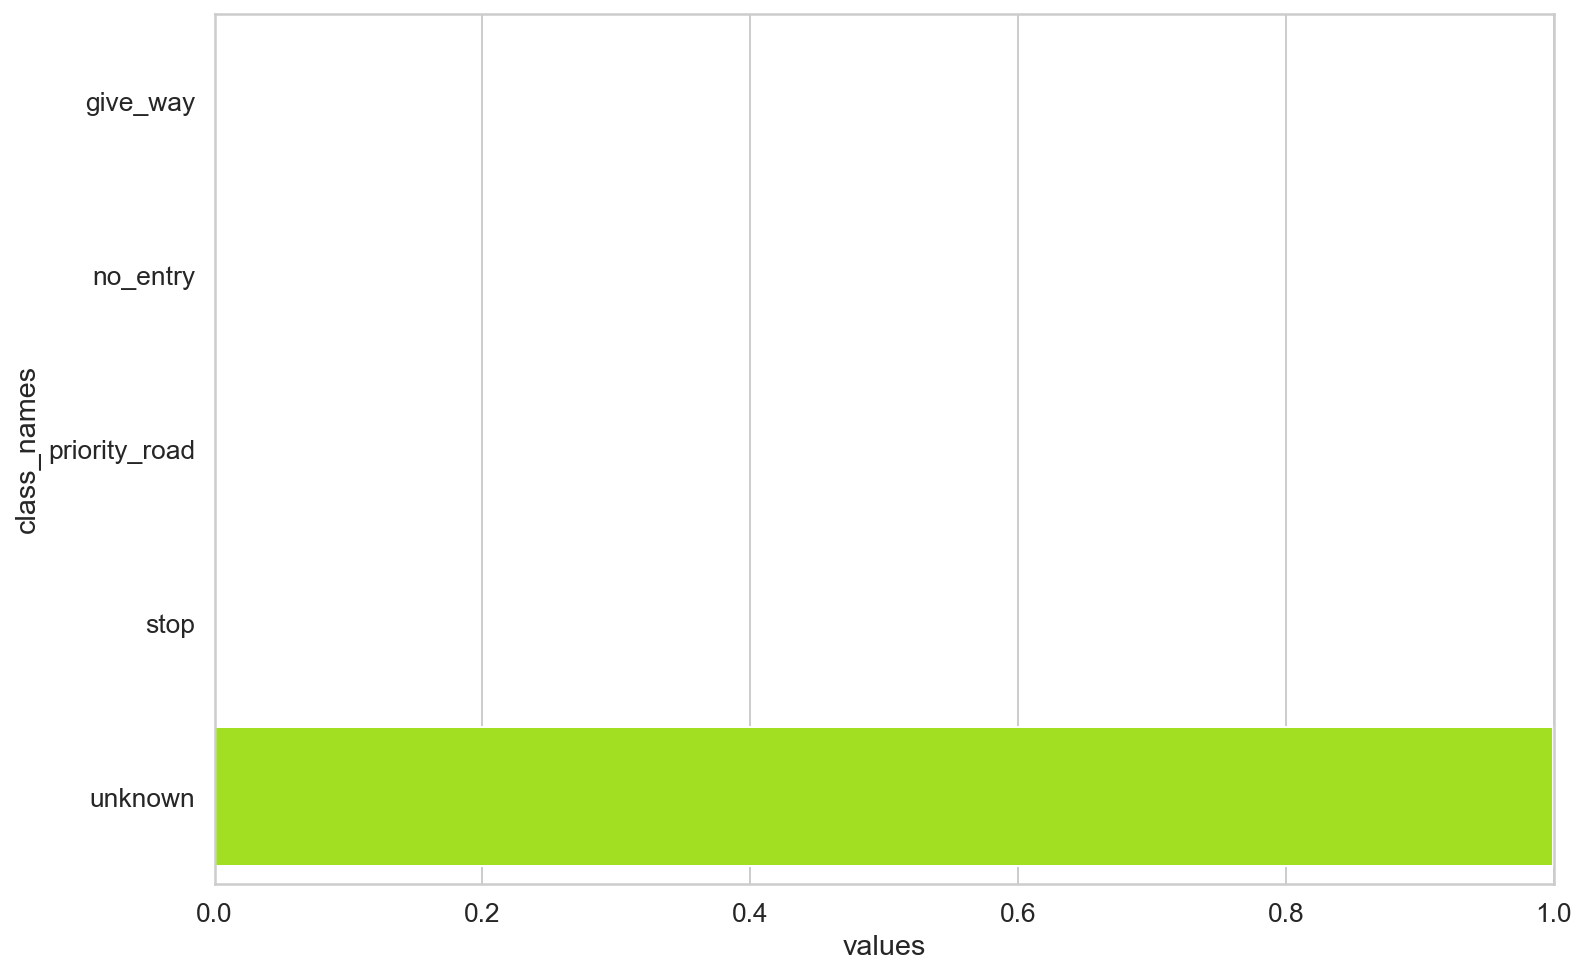

In [96]:
show_prediction_confidence(pred,class_names)

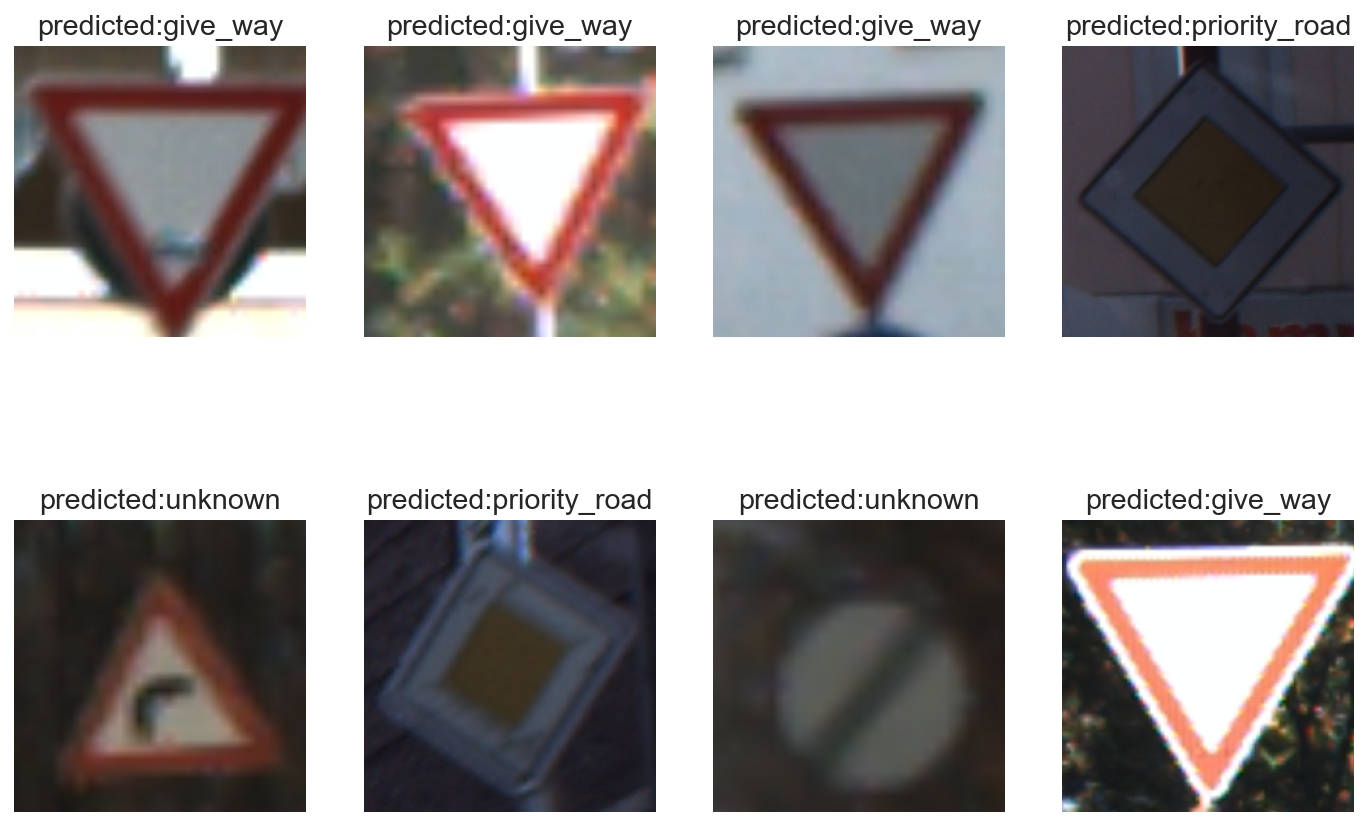

In [97]:
show_prediction(enchanced_model, class_names, n_images=8)

In [98]:
y_pred, y_test = get_predictions(enchanced_model, data_loaders['test'])

In [99]:
print(classification_report(y_test,y_pred,target_names=class_names))

               precision    recall  f1-score   support

     give_way       1.00      0.99      0.99       216
     no_entry       0.52      1.00      0.69       111
priority_road       0.99      1.00      1.00       210
         stop       1.00      1.00      1.00        78
      unknown       1.00      0.63      0.77       269

     accuracy                           0.88       884
    macro avg       0.90      0.92      0.89       884
 weighted avg       0.94      0.88      0.89       884



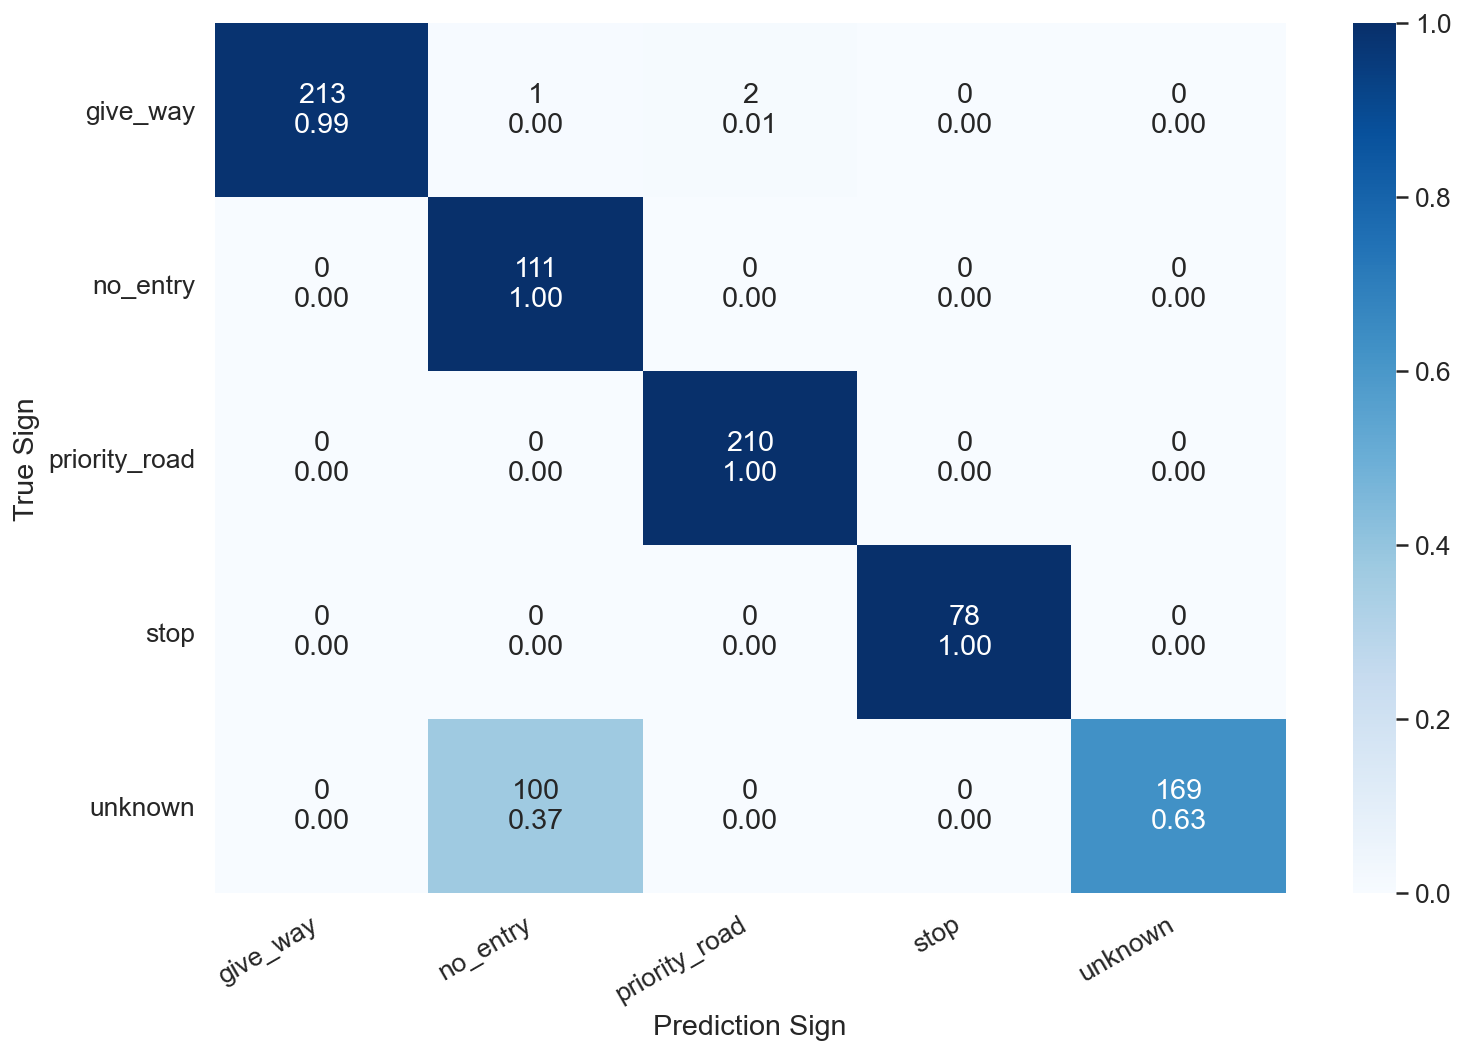

In [100]:
cm = confusion_matrix(y_test,y_pred)
show_confusion_matrix(cm, class_names)